# Data Cleaning, Type Conversion & Validation (Pandas)

This notebook cleans the **Heart Disease Health Indicators** dataset and makes it analysis‑ready.

**What this notebook does**
1. Loads the raw CSV
2. Standardizes column names
3. Converts columns to appropriate dtypes (binary/ordinal as `category`, numeric as numbers)
4. Runs data integrity checks (missing values, duplicates, invalid codes/ranges)
5. Filters out invalid rows using documented value ranges
6. Saves a cleaned dataset for EDA / modeling


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np

# Plot defaults
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)


## 1) Imports

## 2) Load the dataset

In [48]:
url = "https://drive.google.com/uc?id=16DeG8mBHOMjYZYsuoc1r_7ivwMZf6mOA&export=download"
# Read CSV into a DataFrame
df = pd.read_csv(url)
print("Initial shape (rows, cols):", df.shape)
df.head()

Initial shape (rows, cols): (253680, 22)


,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


## 3) Standardize column names

## 3) Standardize column names

In [49]:
# Good practice: remove leading/trailing spaces from column names
# to prevent subtle bugs (e.g., 'BMI ' vs 'BMI').
df.columns = df.columns.str.strip()

df.columns

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

## 4) Define column groups (binary / ordinal / numeric)

These groupings follow the dataset codebook conventions:
- **Binary**: coded as 0/1
- **Ordinal**: coded as integer categories (e.g., Age group 1–13)
- **Numeric**: continuous or count-like measures (BMI, days of poor health)


In [50]:
# Binary (0/1) indicator variables
binary_cols = [
    "HighBP", "HighChol", "CholCheck", "Smoker", "Stroke",
    "PhysActivity", "Fruits", "Veggies",
    "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost",
    "DiffWalk", "Sex"
]

# Ordinal-coded categorical variables
ordinal_cols = ["GenHlth", "Age", "Education", "Income"]

# Numeric variables
numeric_cols = ["BMI", "MentHlth", "PhysHlth", "HeartDiseaseorAttack"]

# Quick check: ensure all expected columns exist
missing_expected = [c for c in (binary_cols + ordinal_cols + numeric_cols) if c not in df.columns]
print("Missing expected columns:", missing_expected)

Missing expected columns: []


## 5) Convert data types (categorical + numeric)

In [51]:
# Convert binary + ordinal to pandas 'category' dtype
# This reduces memory usage and makes EDA/modeling clearer (treated as categories).
for col in binary_cols + ordinal_cols:
    df[col] = df[col].astype("category")

# Convert numeric columns to numeric (coerce invalid strings to NaN)
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   HeartDiseaseorAttack  253680 non-null  int64   
 1   HighBP                253680 non-null  category
 2   HighChol              253680 non-null  category
 3   CholCheck             253680 non-null  category
 4   BMI                   253680 non-null  int64   
 5   Smoker                253680 non-null  category
 6   Stroke                253680 non-null  category
 7   Diabetes              253680 non-null  int64   
 8   PhysActivity          253680 non-null  category
 9   Fruits                253680 non-null  category
 10  Veggies               253680 non-null  category
 11  HvyAlcoholConsump     253680 non-null  category
 12  AnyHealthcare         253680 non-null  category
 13  NoDocbcCost           253680 non-null  category
 14  GenHlth               253680 non-nul

## 6) Missing values & duplicates (integrity checks)

In [52]:
# Missing values per column
missing = df.isna().sum().sort_values(ascending=False)
display(missing.head(15))

# Duplicate rows count (before removal)
dup_count = df.duplicated().sum()
print("Duplicate rows (exact matches):", dup_count)

# Remove duplicates
df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)

HeartDiseaseorAttack    0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
Diabetes                0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
dtype: int64

Duplicate rows (exact matches): 23899
Shape after dropping duplicates: (229781, 22)


## 7) Validate allowed code values (binary columns)

Binary columns must contain only **0 or 1**.
Anything else indicates invalid coding and will be removed.


In [53]:
# Show unique categories for each binary column (after converting to 'category')
for col in binary_cols:
    # categories might include NaN if coercion introduced missing values elsewhere
    print(f"{col}: {list(df[col].cat.categories)}")

HighBP: [0, 1]
HighChol: [0, 1]
CholCheck: [0, 1]
Smoker: [0, 1]
Stroke: [0, 1]
PhysActivity: [0, 1]
Fruits: [0, 1]
Veggies: [0, 1]
HvyAlcoholConsump: [0, 1]
AnyHealthcare: [0, 1]
NoDocbcCost: [0, 1]
DiffWalk: [0, 1]
Sex: [0, 1]


In [54]:
# Keep only rows where all binary columns are exactly 0 or 1
before = df.shape[0]

for col in binary_cols:
    df = df[df[col].isin([0, 1])]

after = df.shape[0]
print("Rows removed by binary validation:", before - after)
print("Shape now:", df.shape)

Rows removed by binary validation: 0
Shape now: (229781, 22)


## 8) Validate numeric/ordinal ranges (codebook + realistic constraints)

We drop rows with values outside these ranges:
- HeartDiseaseorAttack: 0-2
- BMI: 10–80 (removes extreme/outlier coding errors)
- MentHlth, PhysHlth: 0–30 days
- GenHlth: 1–5
- Age: 1–13
- Education: 1–6
- Income: 1–8


In [55]:
valid_ranges = {
    "HeartDiseaseorAttack": (0,2),
    "BMI": (10, 80),
    "MentHlth": (0, 30),
    "PhysHlth": (0, 30),
    "GenHlth": (1, 5),
    "Age": (1, 13),
    "Education": (1, 6),
    "Income": (1, 8)
}

# Before filtering, count invalid values per column (useful for reporting)
invalid_counts = {}
for col, (mn, mx) in valid_ranges.items():
    # Convert to numeric for range checks (categories are stored as numbers underneath)
    s = pd.to_numeric(df[col], errors="coerce")
    invalid_counts[col] = ((s < mn) | (s > mx) | (s.isna())).sum()

pd.Series(invalid_counts).sort_values(ascending=False)

BMI                     279
HeartDiseaseorAttack      0
MentHlth                  0
PhysHlth                  0
GenHlth                   0
Age                       0
Education                 0
Income                    0
dtype: int64

In [56]:
# Apply range filters (drop invalid-coded rows)
before = df.shape[0]

for col, (mn, mx) in valid_ranges.items():
    s = pd.to_numeric(df[col], errors="coerce")
    df = df[(s >= mn) & (s <= mx)]

after = df.shape[0]
print("Rows removed by range validation:", before - after)
print("Final shape:", df.shape)

Rows removed by range validation: 279
Final shape: (229502, 22)


## 9) Final dataset checks

In [57]:
# Confirm no missing values remain in key columns
final_missing = df.isna().sum().sort_values(ascending=False)
display(final_missing.head(15))

# Summary stats for numeric columns
df[numeric_cols].describe()

HeartDiseaseorAttack    0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
Diabetes                0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
dtype: int64

,BMI,MentHlth,PhysHlth,HeartDiseaseorAttack
count,229502.000000,229502.000000,229502.000000,229502.000000
mean,28.615716,3.505189,4.675358,0.103254
std,6.485057,7.713532,9.046249,0.304291
min,12.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000
75%,32.000000,2.000000,4.000000,0.000000
max,80.000000,30.000000,30.000000,1.000000


## 10) Save cleaned dataset

In [58]:
# Save cleaned data for downstream EDA/modeling
cleaned_path = "Heartdisease_analysis_cleaned_Harini_M.csv"
df.to_csv(cleaned_path, index=False)

print("✅ Cleaned dataset saved to:", cleaned_path)

✅ Cleaned dataset saved to: Heartdisease_analysis_cleaned_Harini_M.csv


## 11) Cleaning summary (optional)

This small summary is helpful to copy into your report.


In [59]:
summary = {
    "final_rows": int(df.shape[0]),
    "final_cols": int(df.shape[1]),
    "any_missing_left": bool(df.isna().any().any()),
}
summary

{'final_rows': 229502, 'final_cols': 22, 'any_missing_left': False}

# Data Visualization (Matplotlib + Seaborn)

Data visualization provides a quick and effective way to communicate information in a universal manner using visual representations of complex quantitative and qualitative data.

In this section, we explore a diverse range of techniques to understand patterns related to **heart disease** and associated health metrics.


In [60]:
# Target column for this dataset:
target_col = "HeartDiseaseorAttack"

print("DataFrame shape:", df.shape)
print("Target column:", target_col)


DataFrame shape: (229502, 22)
Target column: HeartDiseaseorAttack


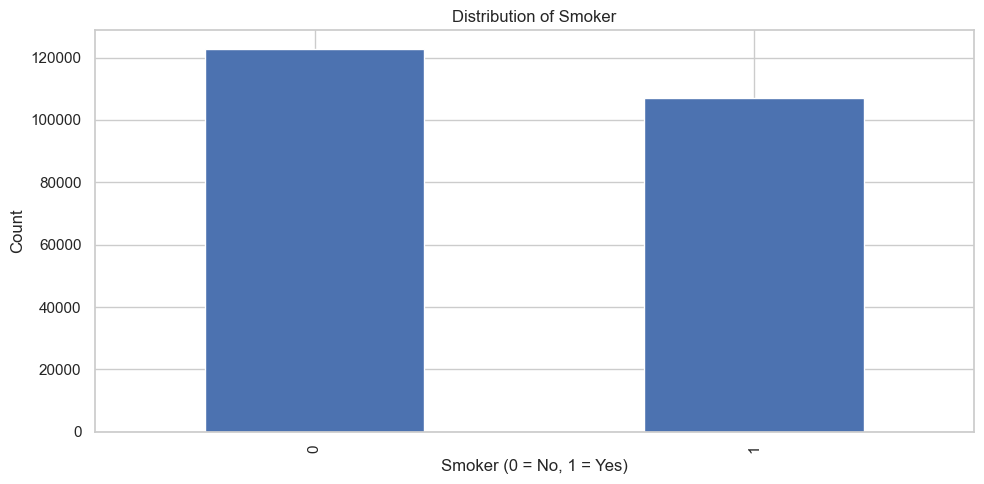

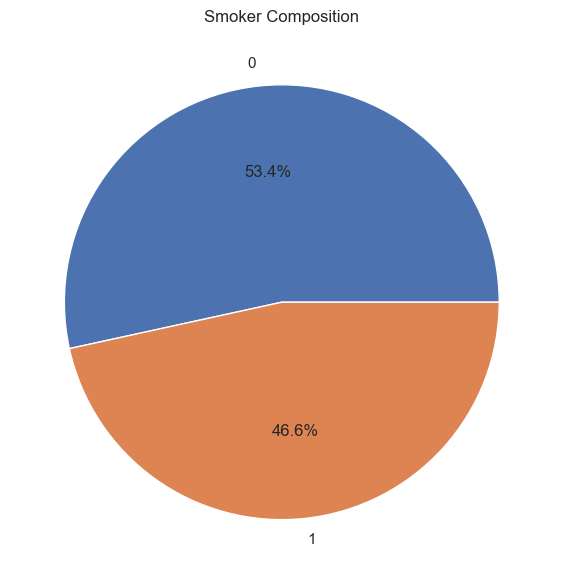

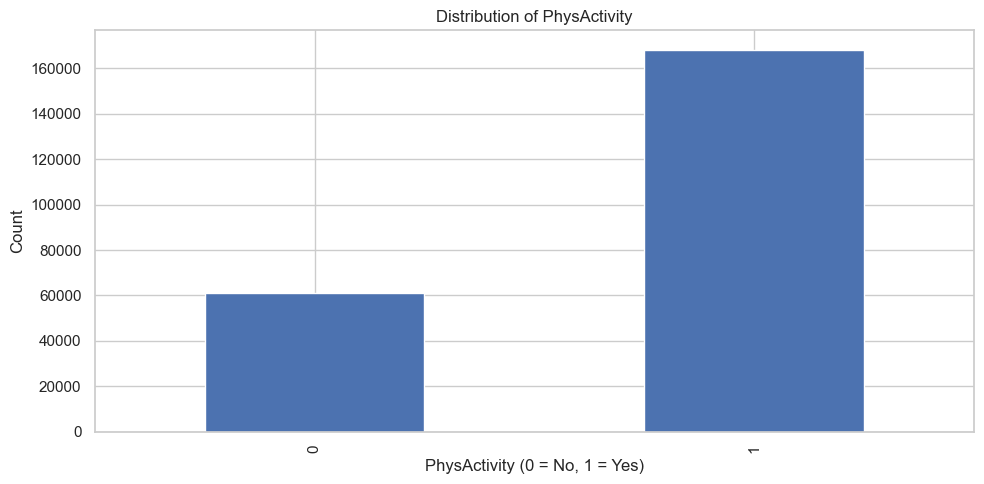

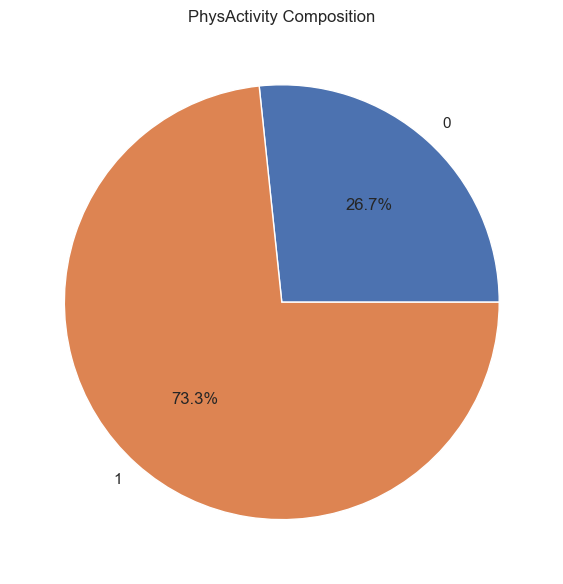

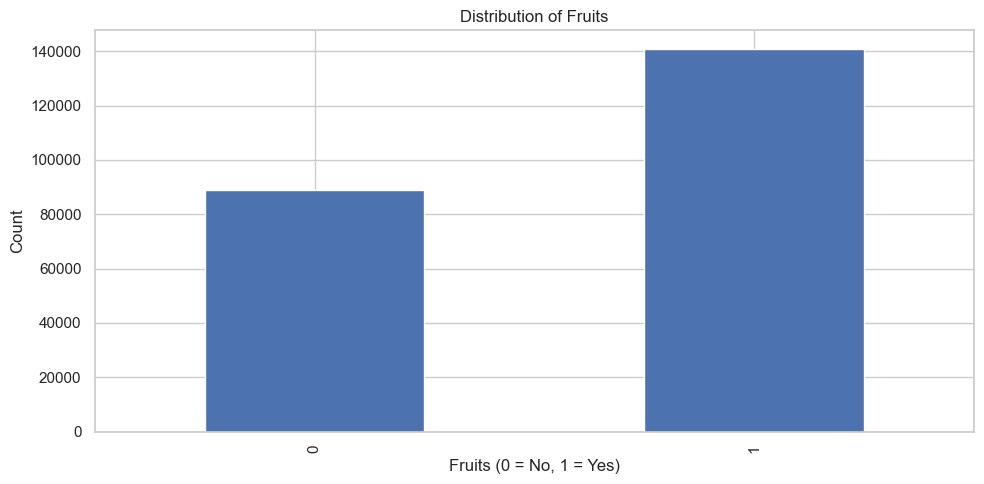

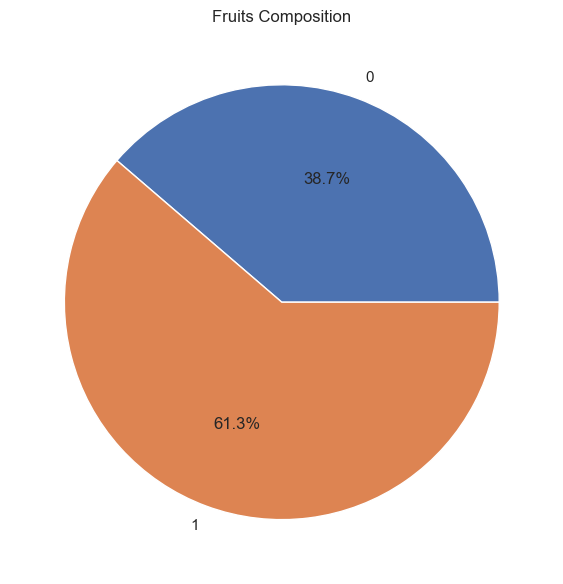

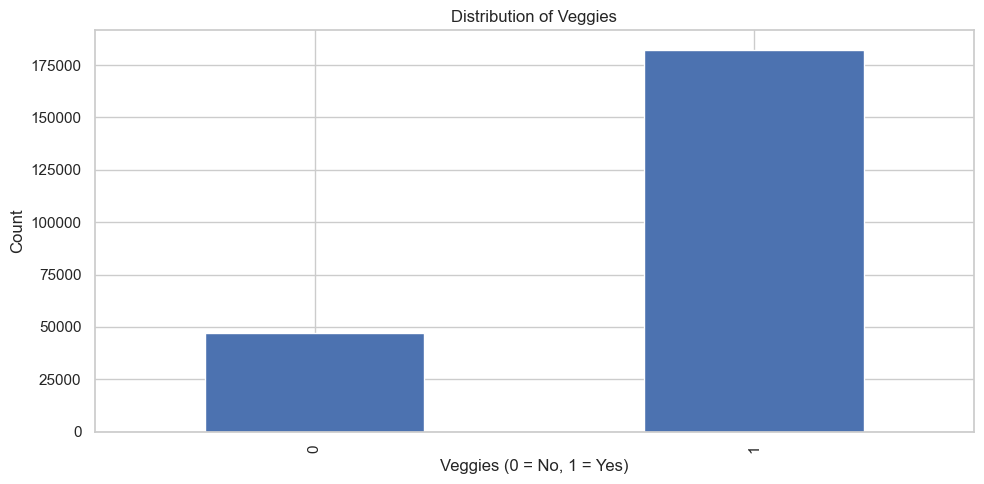

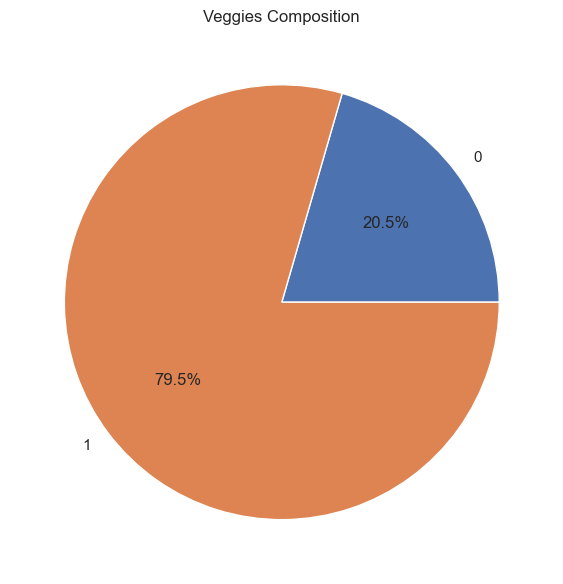

In [61]:
# ------------------------------------------------------
# 1) Bar Plots and Pie Charts
#    a) Visualize Categorical Variables
# ------------------------------------------------------
categorical_vars = ["Smoker", "PhysActivity", "Fruits", "Veggies"]

for col in categorical_vars:
    if col not in df.columns:
        print(f"Skipping '{col}' (not found).")
        continue

    counts = df[col].value_counts().sort_index()

    # Bar chart
    ax = counts.plot(kind="bar")
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(f"{col} (0 = No, 1 = Yes)")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(counts.values, labels=[str(i) for i in counts.index], autopct="%1.1f%%")
    plt.title(f"{col} Composition")
    plt.tight_layout()
    plt.show()


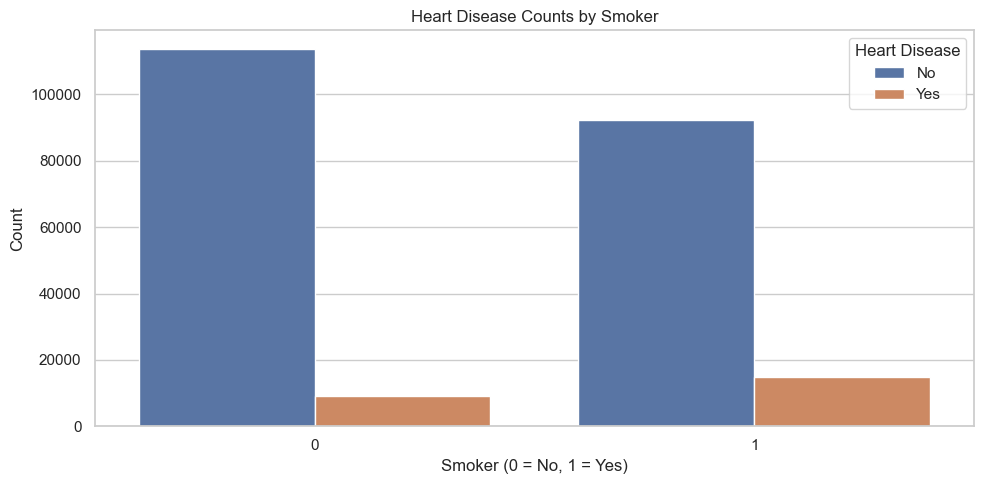

/var/folders/t8/bb_mvw4x7r50pgd11r5d2zbm0000gn/T/ipykernel_14977/1898466818.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = df.groupby([col, target_col]).size().unstack(fill_value=0).sort_index()


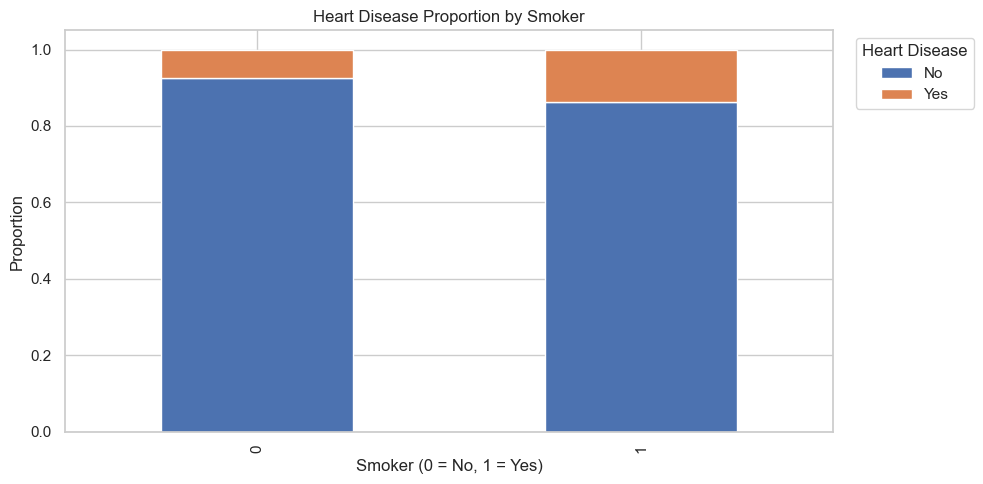

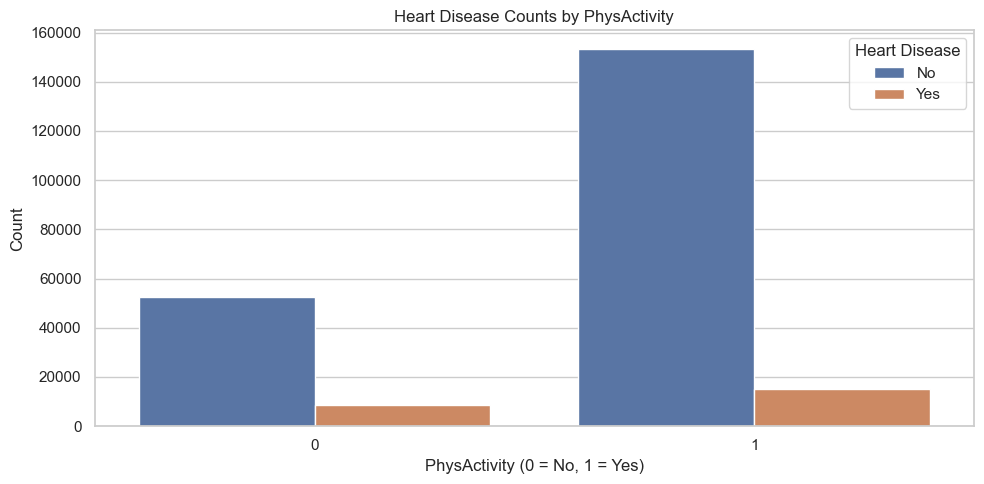

/var/folders/t8/bb_mvw4x7r50pgd11r5d2zbm0000gn/T/ipykernel_14977/1898466818.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = df.groupby([col, target_col]).size().unstack(fill_value=0).sort_index()


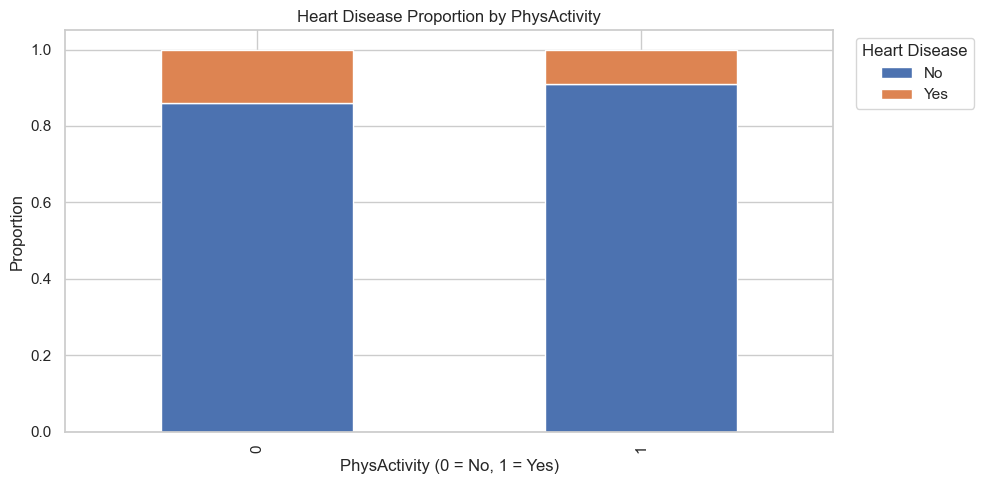

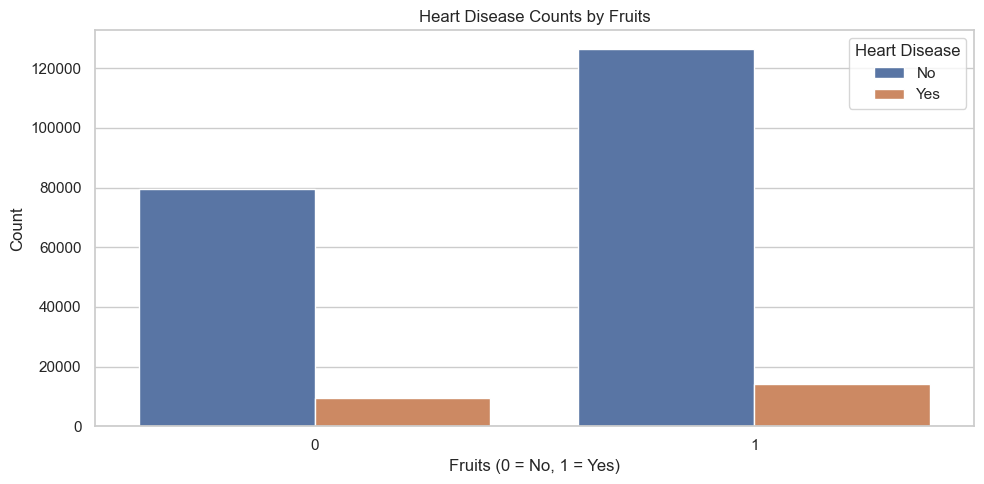

/var/folders/t8/bb_mvw4x7r50pgd11r5d2zbm0000gn/T/ipykernel_14977/1898466818.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = df.groupby([col, target_col]).size().unstack(fill_value=0).sort_index()


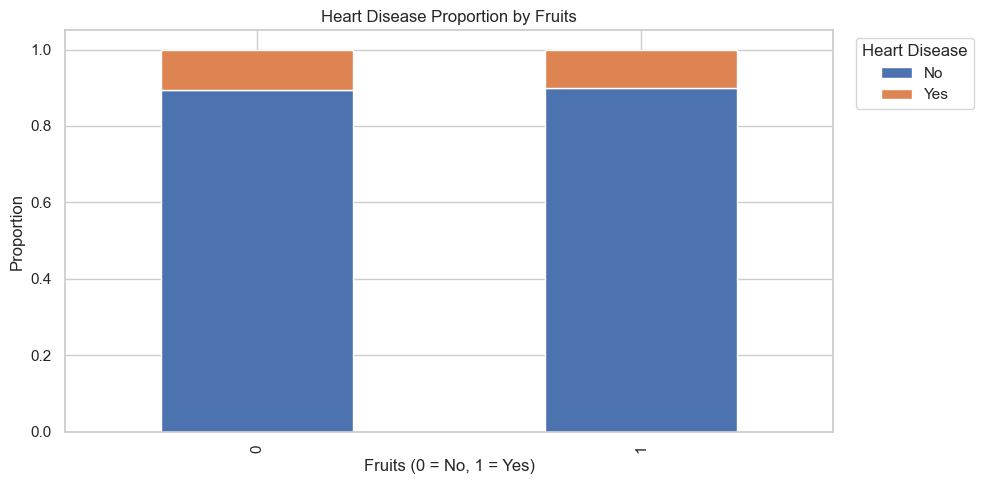

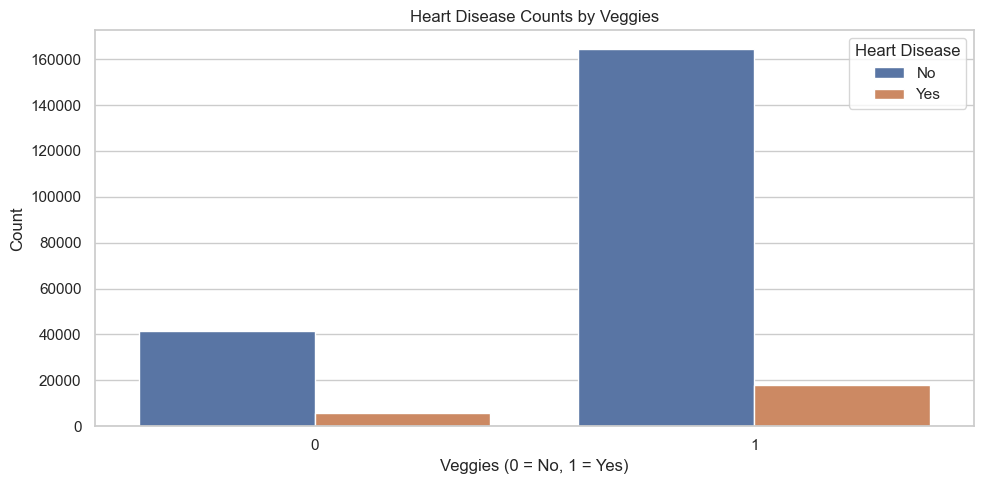

/var/folders/t8/bb_mvw4x7r50pgd11r5d2zbm0000gn/T/ipykernel_14977/1898466818.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = df.groupby([col, target_col]).size().unstack(fill_value=0).sort_index()


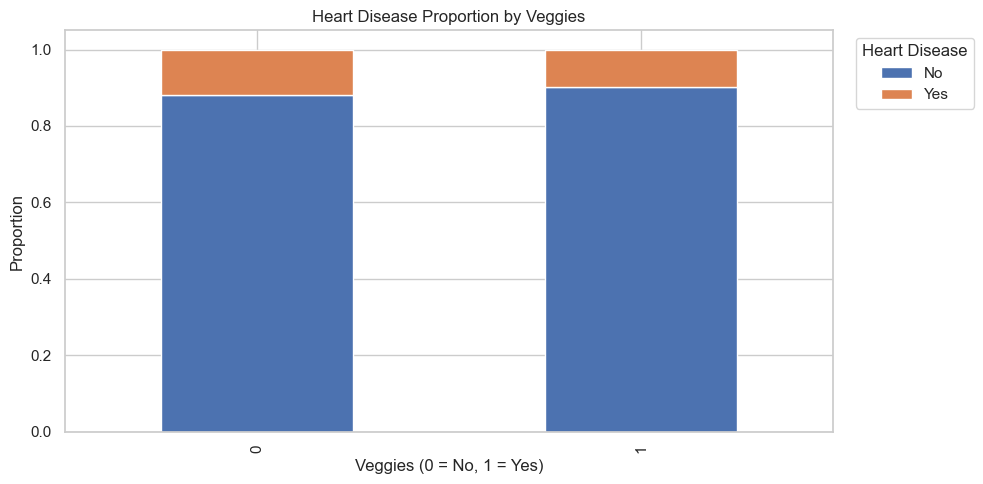

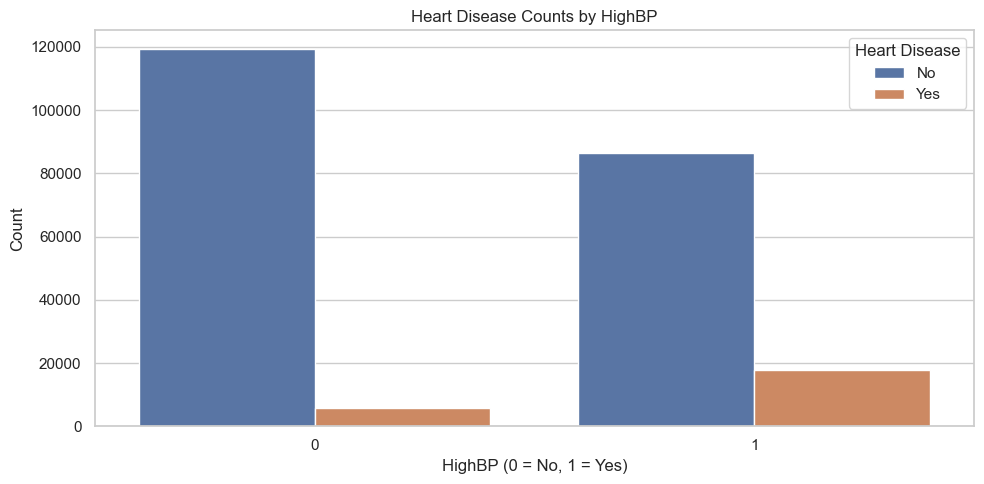

/var/folders/t8/bb_mvw4x7r50pgd11r5d2zbm0000gn/T/ipykernel_14977/1898466818.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = df.groupby([col, target_col]).size().unstack(fill_value=0).sort_index()


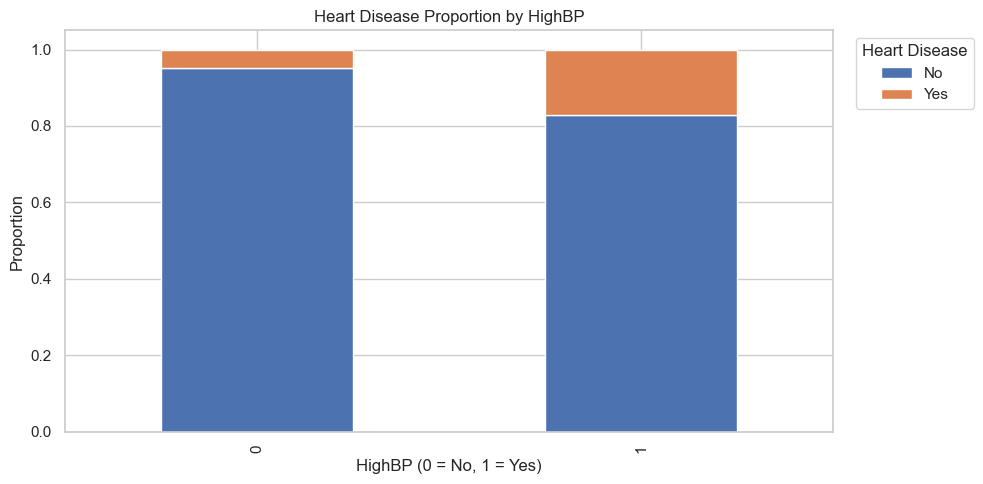

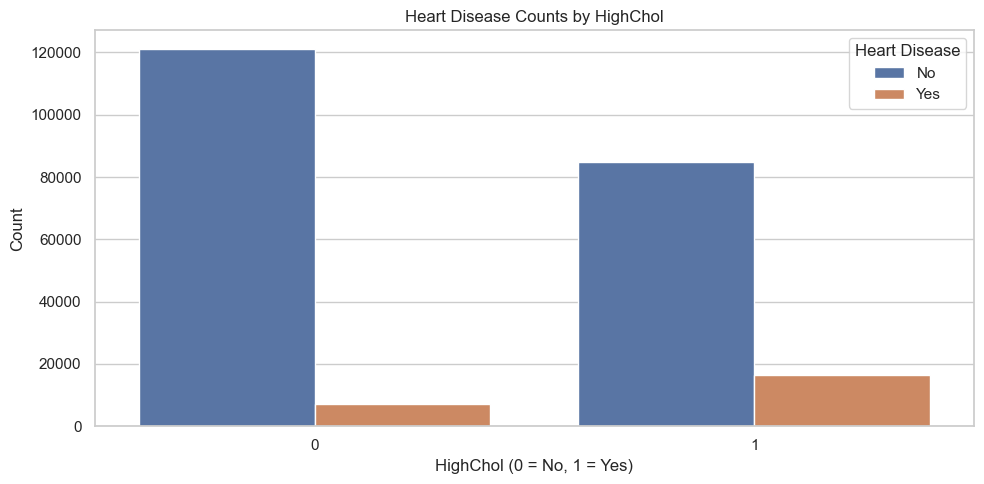

/var/folders/t8/bb_mvw4x7r50pgd11r5d2zbm0000gn/T/ipykernel_14977/1898466818.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = df.groupby([col, target_col]).size().unstack(fill_value=0).sort_index()


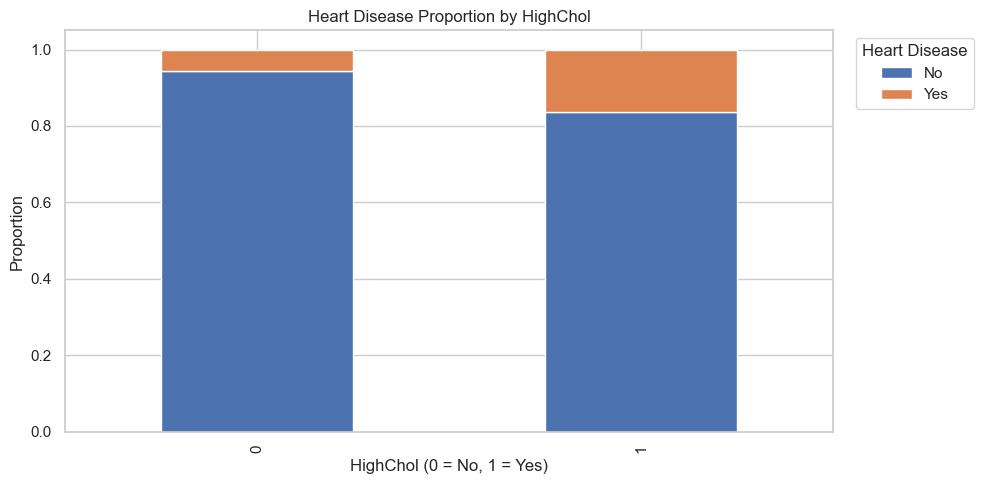

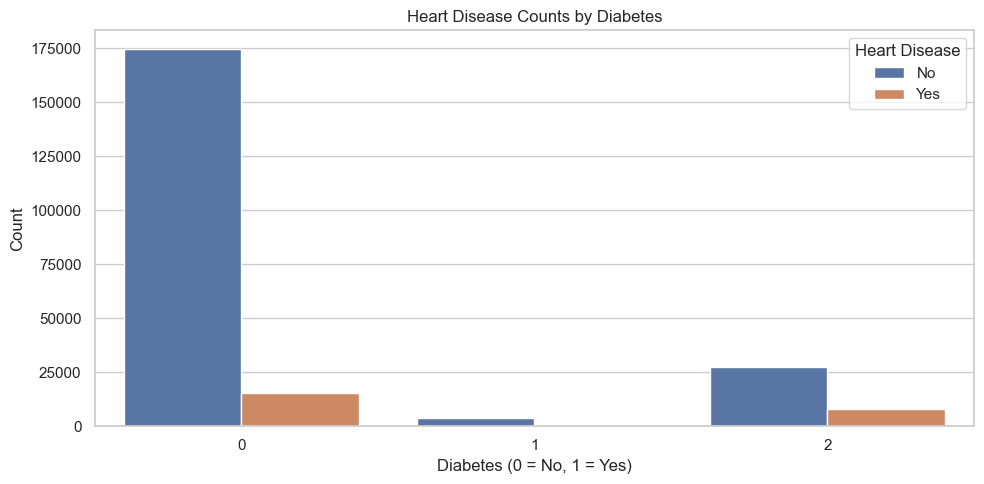

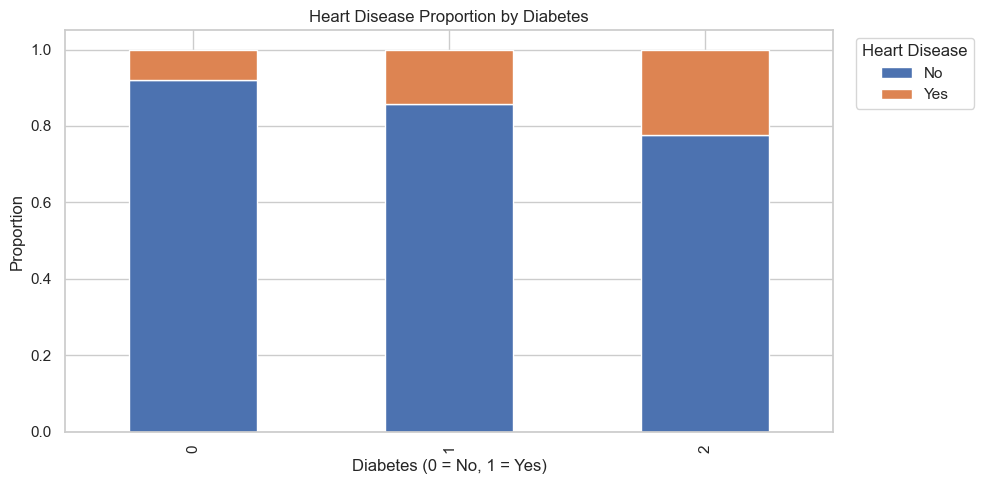

In [62]:
# ------------------------------------------------------
# 2) Compare Heart Disease Across Categories
#    b) Grouped + Stacked Bar Charts
# ------------------------------------------------------
compare_vars = ["Smoker", "PhysActivity", "Fruits", "Veggies", "HighBP", "HighChol", "Diabetes"]

for col in compare_vars:
    if col not in df.columns:
        print(f"Skipping '{col}' (not found).")
        continue

    # Grouped bar (counts)
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=df, x=col, hue=target_col)
    ax.set_title(f"Heart Disease Counts by {col}")
    ax.set_xlabel(f"{col} (0 = No, 1 = Yes)")
    ax.set_ylabel("Count")
    plt.legend(title="Heart Disease", labels=["No", "Yes"])
    plt.tight_layout()
    plt.show()

    # Stacked bar (proportions within each category)
    ct = df.groupby([col, target_col]).size().unstack(fill_value=0).sort_index()
    props = ct.div(ct.sum(axis=1), axis=0)

    ax = props.plot(kind="bar", stacked=True, figsize=(10, 5))
    ax.set_title(f"Heart Disease Proportion by {col}")
    ax.set_xlabel(f"{col} (0 = No, 1 = Yes)")
    ax.set_ylabel("Proportion")
    plt.legend(title="Heart Disease", labels=["No", "Yes"], bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


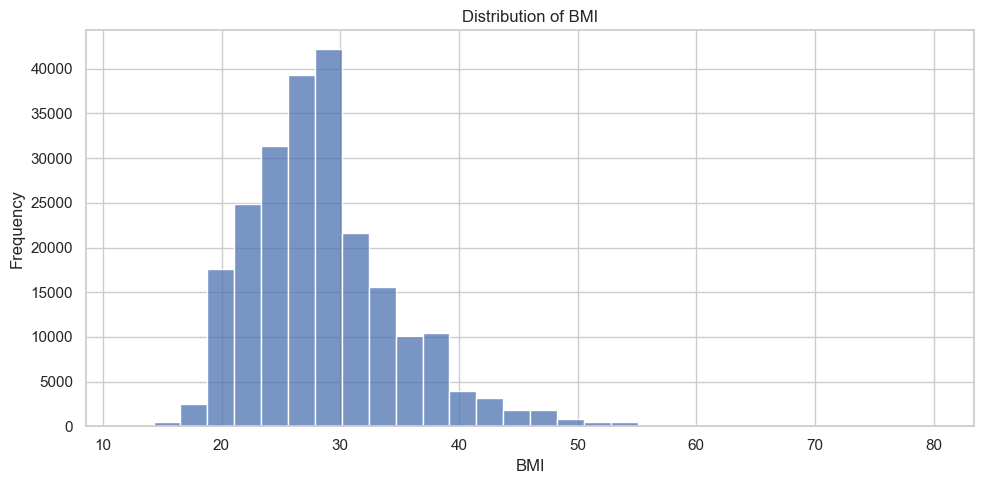

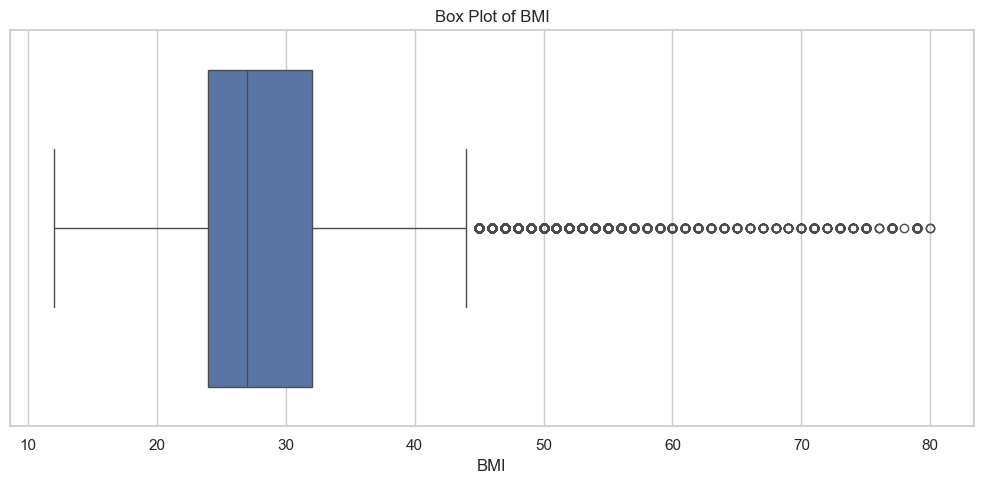

Skipping 'Menthlth' (not found).


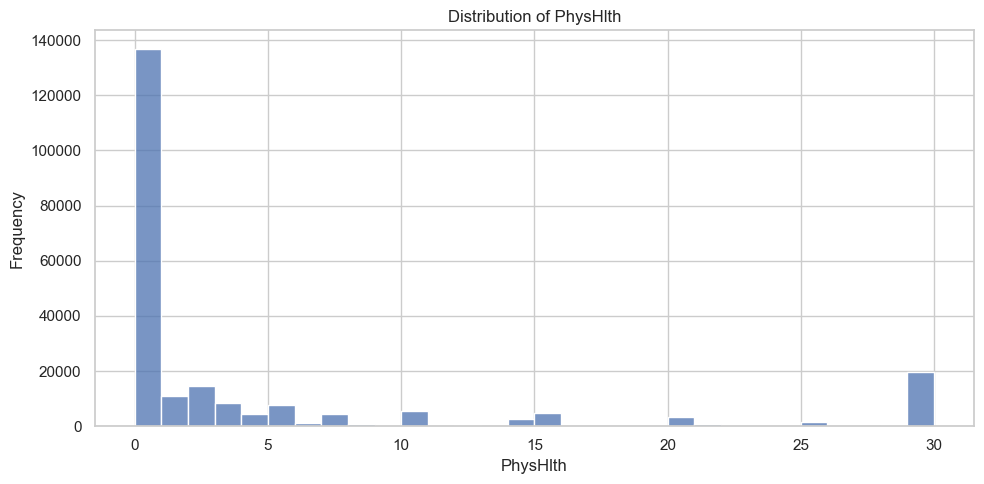

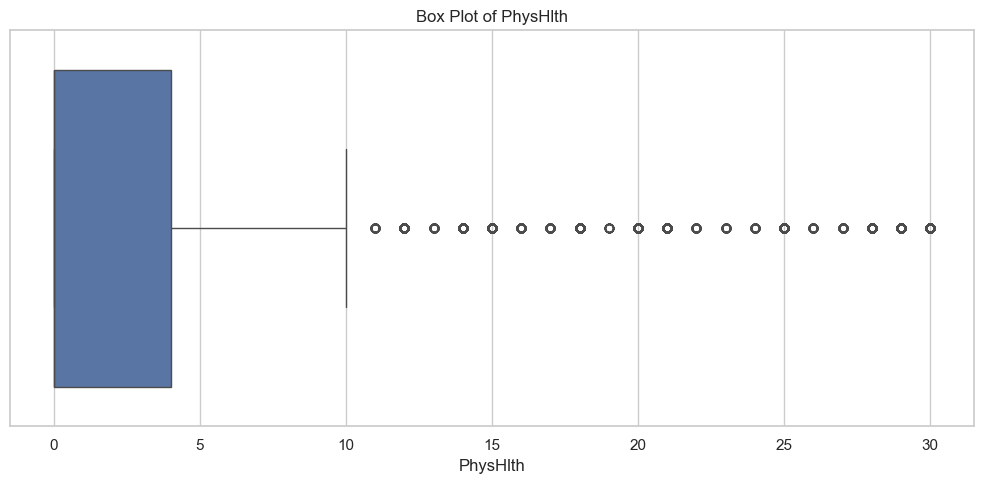

In [63]:
# ------------------------------------------------------
# 3) Continuous Variable Distributions
#    a) Histograms + Box Plots
# ------------------------------------------------------
continuous_vars = ["BMI", "Menthlth", "PhysHlth"]

for col in continuous_vars:
    if col not in df.columns:
        print(f"Skipping '{col}' (not found).")
        continue

    # Histogram
    ax = sns.histplot(data=df, x=col, bins=30, kde=False)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Box plot
    ax = sns.boxplot(data=df, x=col)
    ax.set_title(f"Box Plot of {col}")
    plt.tight_layout()
    plt.show()


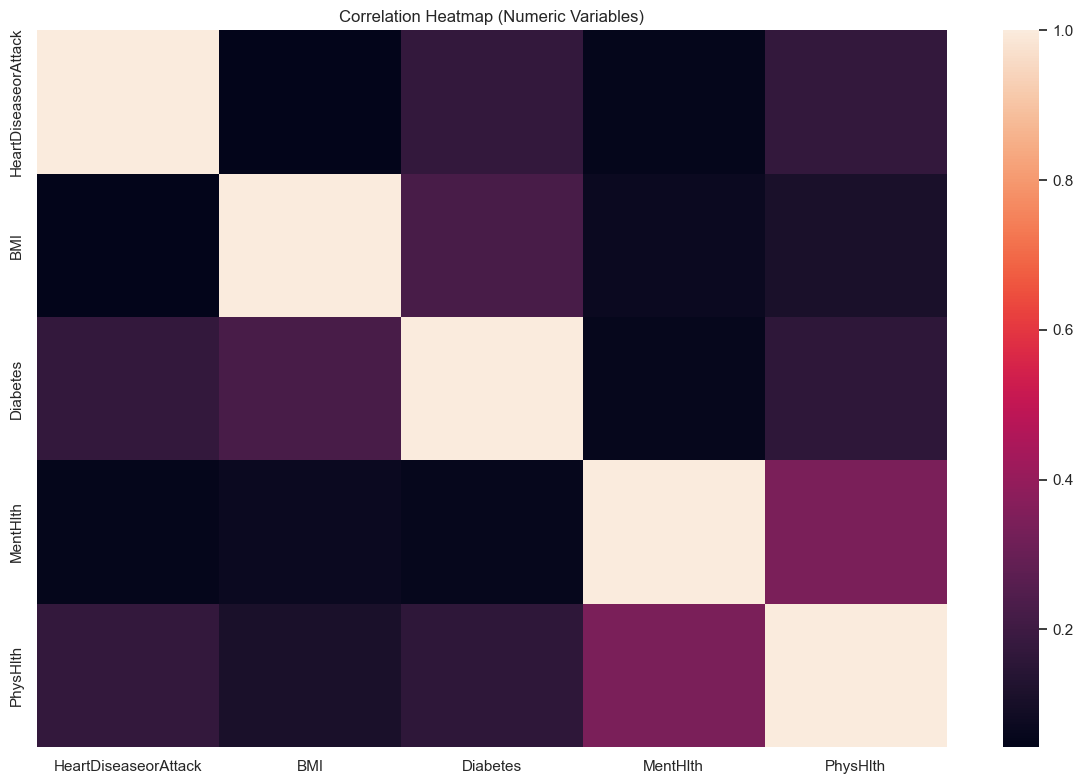

In [64]:
# ------------------------------------------------------
# 4) Heatmaps and Correlation Plots
#    b) Explore Variable Relationships
# ------------------------------------------------------
num_df = df.select_dtypes(include=["number"])
corr = num_df.corr()

plt.figure(figsize=(12, 8))
ax = sns.heatmap(corr, annot=False)
ax.set_title("Correlation Heatmap (Numeric Variables)")
plt.tight_layout()
plt.show()


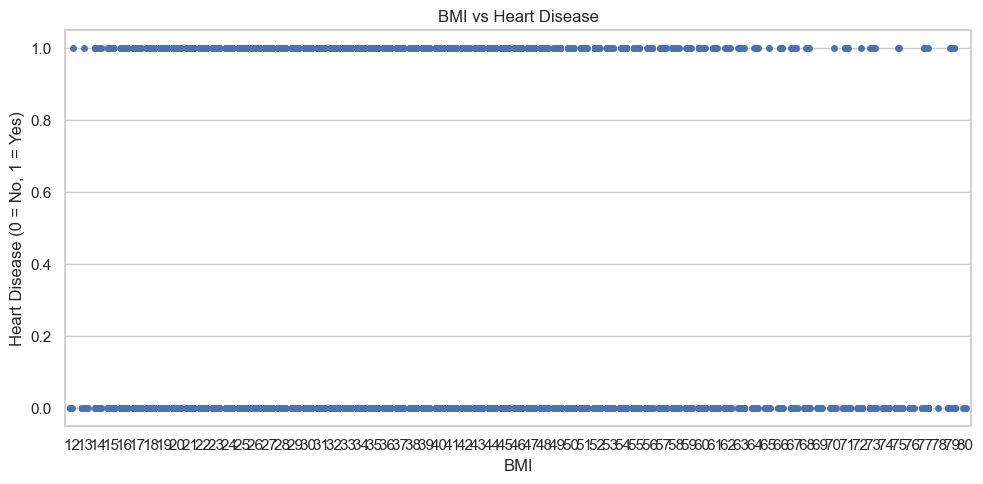

Skipping Menthlth vs HeartDiseaseorAttack (missing column).


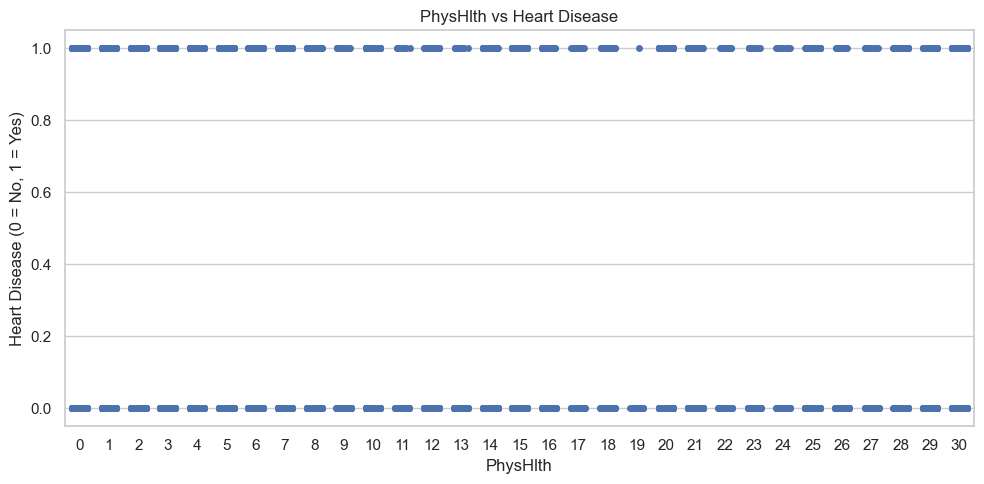

In [65]:
# ------------------------------------------------------
# 5) Scatter Plots
#    c) Relationships potentially linked to heart disease
# ------------------------------------------------------
scatter_pairs = [("BMI", target_col), ("Menthlth", target_col), ("PhysHlth", target_col)]

for x, y in scatter_pairs:
    if x not in df.columns or y not in df.columns:
        print(f"Skipping {x} vs {y} (missing column).")
        continue

    # For binary target, use strip plot for readability
    ax = sns.stripplot(data=df, x=x, y=y, jitter=0.25)
    ax.set_title(f"{x} vs Heart Disease")
    ax.set_xlabel(x)
    ax.set_ylabel("Heart Disease (0 = No, 1 = Yes)")
    plt.tight_layout()
    plt.show()


/var/folders/t8/bb_mvw4x7r50pgd11r5d2zbm0000gn/T/ipykernel_14977/2561449126.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_rate = df.groupby("Age")[target_col].mean().sort_index()


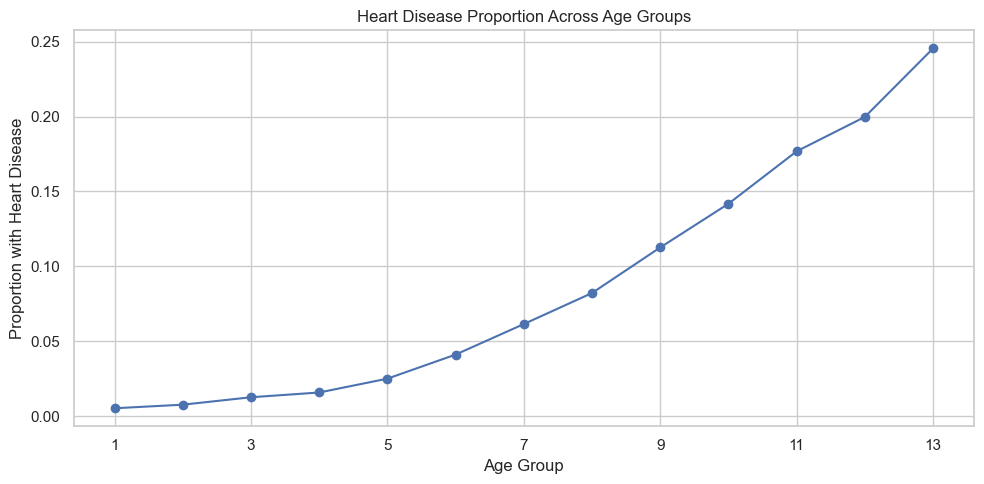

In [66]:
# ------------------------------------------------------
# 6) Line Plots
#    d) Trends across ordered categories (Age groups)
# ------------------------------------------------------
if "Age" in df.columns:
    age_rate = df.groupby("Age")[target_col].mean().sort_index()
    ax = age_rate.plot(kind="line", marker="o")
    ax.set_title("Heart Disease Proportion Across Age Groups")
    ax.set_xlabel("Age Group")
    ax.set_ylabel("Proportion with Heart Disease")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping line plot: 'Age' column not found.")


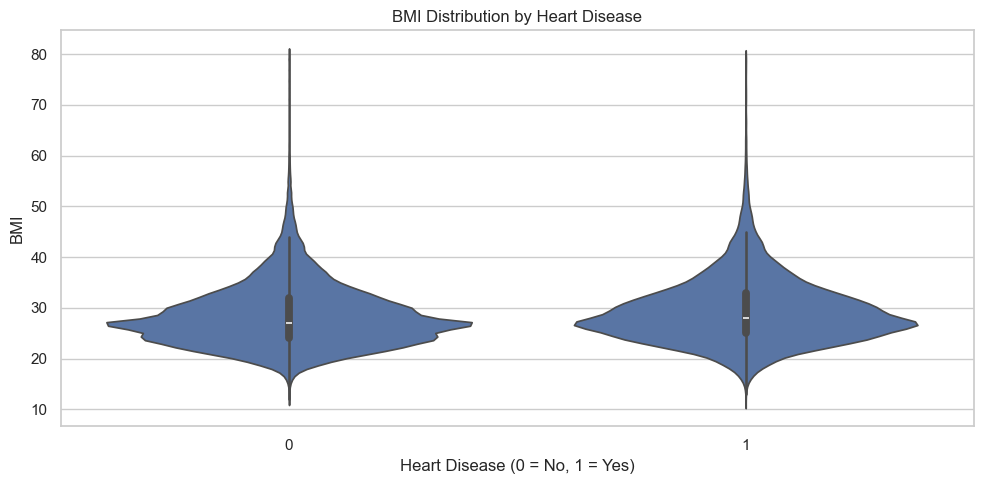

Skipping 'Menthlth' (not found).


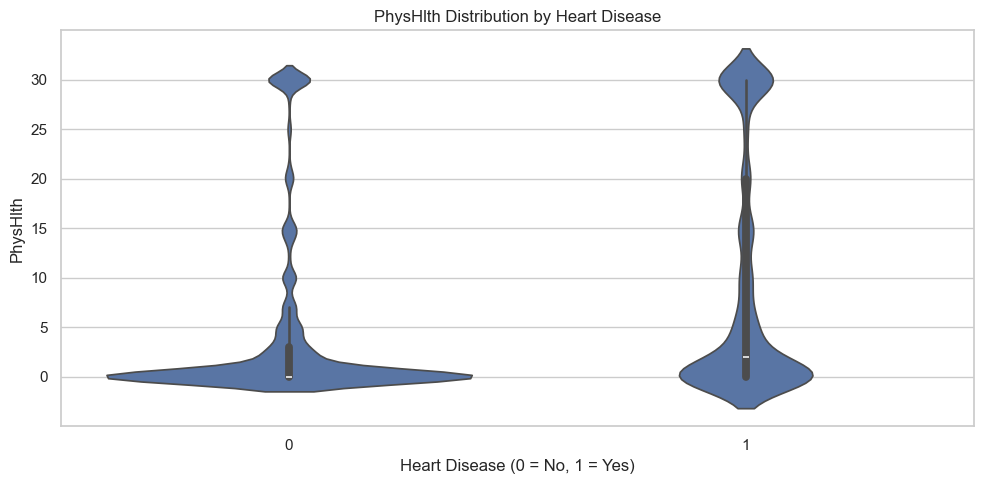

In [67]:
# ------------------------------------------------------
# 7) Violin Plots
#    e) Distribution shape by heart disease class
# ------------------------------------------------------
violin_vars = ["BMI", "Menthlth", "PhysHlth"]
for col in violin_vars:
    if col not in df.columns:
        print(f"Skipping '{col}' (not found).")
        continue

    ax = sns.violinplot(data=df, x=target_col, y=col)
    ax.set_title(f"{col} Distribution by Heart Disease")
    ax.set_xlabel("Heart Disease (0 = No, 1 = Yes)")
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()


In [ ]:
# ------------------------------------------------------
# 8) Pair Plots (sampled)
#    f) Pairwise relationships across multiple variables
# ------------------------------------------------------
pair_cols = ["BMI", "Menthlth", "PhysHlth", "Age", target_col]
pair_cols = [c for c in pair_cols if c in df.columns]

# Sample to keep it fast on large datasets
sample_df = df[pair_cols].dropna().sample(n=min(2000, len(df)), random_state=42).copy()
sample_df[target_col] = sample_df[target_col].astype(int).astype(str)

sns.pairplot(sample_df, hue=target_col, corner=True)
plt.suptitle("Pair Plot (Sampled) — Key Variable Relationships", y=1.02)
plt.show()



# How to Read the Visualizations

These plots are designed to reveal patterns related to cardiovascular risk.

**What to focus on:**
- Bar & pie charts → overall population lifestyle habits
- Grouped/stacked bars → how lifestyle and clinical factors relate to heart disease
- Histograms & box plots → distribution and spread of health metrics
- Heatmap → relationships between numeric variables
- Scatter/strip plots → how risk factors vary with heart disease
- Line plot → how heart disease risk changes across age groups
- Violin & pair plots → deeper distribution and multi-variable relationships



# Final Insights & Summary

## Key Observations
- Heart disease affects a smaller portion of the dataset but remains significant.
- Age shows a clear upward trend with heart disease prevalence.
- High blood pressure, high cholesterol, and diabetes strongly align with heart disease.
- Lifestyle variables (smoking, inactivity, poor diet) amplify existing clinical risks.
- BMI distribution indicates widespread overweight status in the population.
- Mental and physical health days show a small group experiencing prolonged distress.

## Overall Conclusion
Heart disease risk in this dataset is **predictable and multi-factorial**.  
Clinical indicators act as primary drivers, while lifestyle and socioeconomic factors act as **risk amplifiers**.
